# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
optimizer = Adam(lr=0.0001)

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
df['real_age'].value_counts().to_frame().head()

In [6]:
df['real_age'].value_counts().to_frame().tail()

,real_age
96,2
100,1
93,1
91,1
97,1


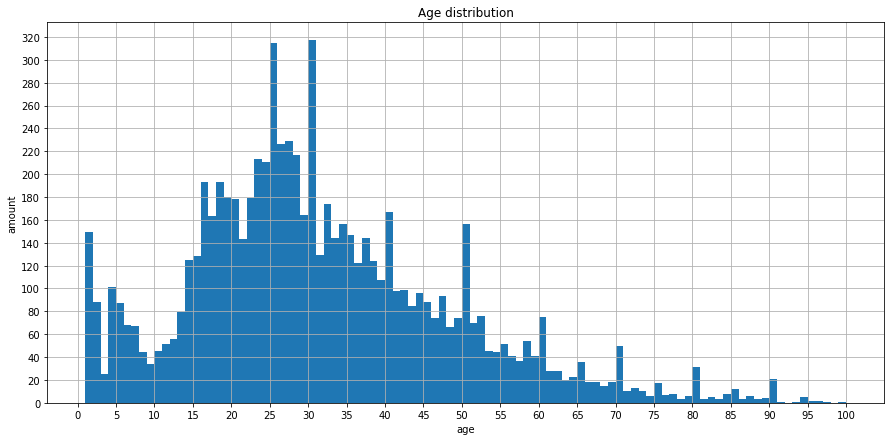

In [7]:
plt.figure(figsize=(15,7))
plt.hist(df['real_age'], bins=99)
plt.title('Age distribution')
plt.grid()
plt.xlabel('age')
plt.ylabel('amount')
plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.arange(0, 321, 20))
plt.show()

In [8]:
datagen = ImageDataGenerator(rescale=1/255.)
train_datagen_flow = datagen.flow_from_dataframe(dataframe=df, directory='/datasets/faces/final_files/',
                    x_col='file_name', y_col='real_age',
                    target_size=(150, 150), batch_size=16, class_mode='raw', seed=12345)

Found 7591 validated image filenames.


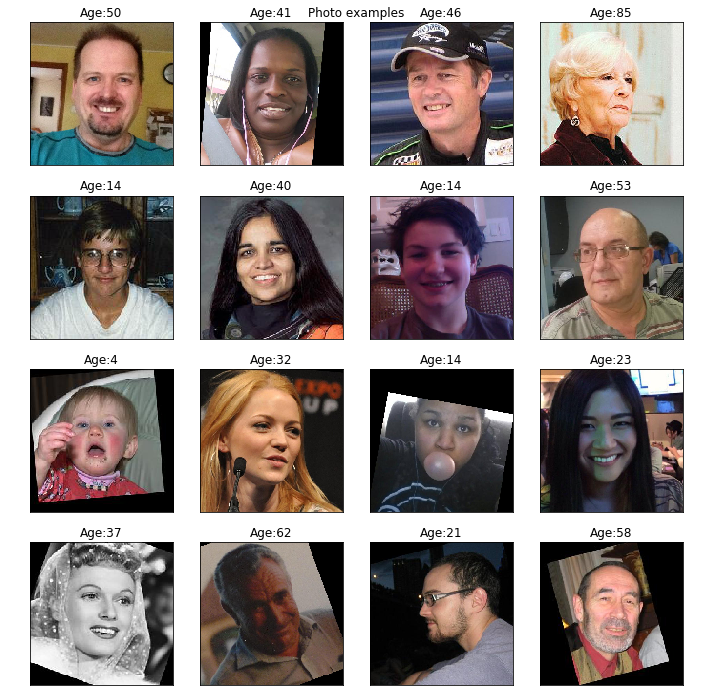

In [9]:
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
plt.title('Photo examples')
plt.axis('off')
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Age:'+str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

Минимальный возраст - 1 год, максимальный 100 лет, медианное значение при этом составляет 29 лет. Больше всего фотографий людей от 25 до 30 лет, меньше всего от 90 до 100. На гистограмме видно, что на каждой декаде лет после 30 (30, 40, 50...) количество фотографий больше, чем в их диапазоне.

Представленны фотографии лиц людей: цветные и черно-белые, разной четкости и степени освещения. На некоторых из них люди не смотрят в камеру или повернуты в сторону. Присутствуют целиком повернутые изображения.

## Обучение модели

```python
def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(99,activation='relu'))
    model.add(Dense(75,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
2021-10-24 13:25:33.189074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-24 13:25:33.476049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 44s - loss: 232.0667 - mae: 11.1001 - val_loss: 473.8441 - val_mae: 16.6193
Epoch 2/15
356/356 - 35s - loss: 83.3134 - mae: 7.0046 - val_loss: 164.1517 - val_mae: 9.4574
Epoch 3/15
356/356 - 35s - loss: 58.2639 - mae: 5.8554 - val_loss: 81.6845 - val_mae: 6.7313
Epoch 4/15
356/356 - 35s - loss: 42.6029 - mae: 4.9360 - val_loss: 81.4108 - val_mae: 6.8336
Epoch 5/15
356/356 - 35s - loss: 31.8600 - mae: 4.2864 - val_loss: 75.7602 - val_mae: 6.5389
Epoch 6/15
356/356 - 35s - loss: 22.6955 - mae: 3.6311 - val_loss: 74.6507 - val_mae: 6.3906
Epoch 7/15
356/356 - 35s - loss: 18.0905 - mae: 3.2115 - val_loss: 71.8034 - val_mae: 6.3843
Epoch 8/15
356/356 - 35s - loss: 14.5201 - mae: 2.8949 - val_loss: 69.5768 - val_mae: 6.3868
Epoch 9/15
356/356 - 35s - loss: 13.0685 - mae: 2.7355 - val_loss: 70.4005 - val_mae: 6.2048
Epoch 10/15
356/356 - 35s - loss: 12.5921 - mae: 2.6708 - val_loss: 80.2154 - val_mae: 6.9412
Epoch 11/15
356/356 - 35s - loss: 13.0315 - mae: 2.7317 - val_loss: 73.3108 - val_mae: 6.4965
Epoch 12/15
356/356 - 36s - loss: 13.6059 - mae: 2.8170 - val_loss: 76.7542 - val_mae: 6.6448
Epoch 13/15
356/356 - 35s - loss: 13.6878 - mae: 2.7320 - val_loss: 70.0816 - val_mae: 6.1929
Epoch 14/15
356/356 - 35s - loss: 12.3982 - mae: 2.6532 - val_loss: 80.8820 - val_mae: 6.6643
Epoch 15/15
356/356 - 35s - loss: 11.8057 - mae: 2.5945 - val_loss: 72.2934 - val_mae: 6.2644
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 72.2934 - mae: 6.2644
Test MAE: 6.2644

```

## Анализ обученной модели

Модель обучена при помощи ResNet50 за 15 эпох при помощи алгоритма оптимизации Adam с шагом 0.0001. При большем шаге модель достаточно быстро начинает переобучаться.  
В обучающей выборке использовались аугментации горизонтального поворота.  
MAE на тренировочной выборке: 2.5945  
MAE на тренировочной выборке: 6.2644

Модель достаточно хорошо определяет приблизительный возраст человека, чтобы отнести его в определенную возрастную группу на основании которой можно анализировать покупаемые товары и предлагать потенциально интересные. Продажа алкоголя производится с четко определенного возраста, модель может быть недостаточно точной для такого определения.